In [59]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import re
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import lognorm

In [60]:
def getPopSizeOverTimeFromFile(filename):
    
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter="\t")
        nCols = len(next(reader)) #gets the no. of columns in file, i.e., features of data
        # also this skips the first line, which is all headers
        
        column_array = [[] for i in range(nCols)] #creates an empty array of length nCols to store the data
        
        
        for row in reader:
            for i in range(len(row)):
                column_array[i].append(float(row[i].strip()))
                
        return column_array
        
        
        
        
times, nAlive, nDead = getPopSizeOverTimeFromFile('data/Pyrithione_testing_c=10.0.txt') 
#print(nAlive)

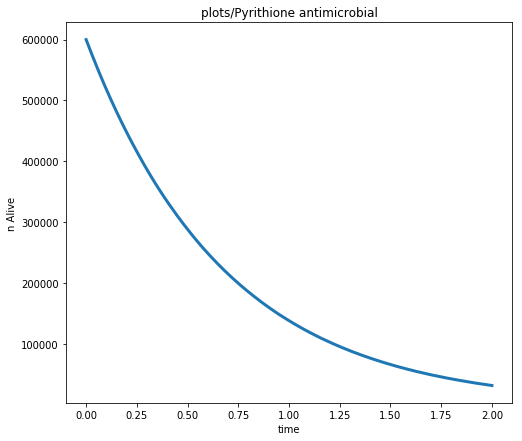

In [61]:
def plotPyrithioneTestingResults(tData, liveData, deadData):
    
    plt.figure(figsize=(8,7))
    plt.plot(tData, liveData, linewidth=3)
    plt.xlabel('time')
    plt.ylabel('n Alive')
    plt.title('plots/'+'Pyrithione antimicrobial')
    #plt.savefig('pyrithione_testing_c=10.0.png')
    plt.show()
    
plotPyrithioneTestingResults(times, nAlive, nDead)

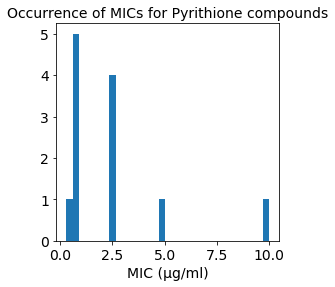

In [62]:
def histogramOfPyrithioneMIC():
    
    #gram-negative bacteria
    listOfMICs = [2.5, 2.5, 5.0, 80.0, 2.5, 10.0]
    #gram-positive bacteria
    listOfMICs2 = [0.6, 0.6, 0.6, 0.6, 0.3, 2.5, 0.6]
    #yeasts
    #listOfMICs3 = [0.15, 1.25, 0.15, 0.3, 0.2]
    
    allMICs = listOfMICs+listOfMICs2
    
    font_size = 14
    
    plt.figure(figsize=(8,7))
    plt.hist(allMICs, bins=100)
    
    plt.tick_params(labelsize=14)
    plt.title('Occurrence of MICs for Pyrithione compunds', fontsize=font_size)
    plt.xlabel('MIC (μg/ml)', fontsize=font_size)

    plt.savefig('plots/'+'Pyrithione-MIC-histogram.png')
    plt.show()
    

def histogramOfPyrithioneMIC_noOutlier():
    
    #gram-negative bacteria
    listOfMICs = [2.5, 2.5, 5.0, 2.5, 10.0]
    #gram-positive bacteria
    listOfMICs2 = [0.6, 0.6, 0.6, 0.6, 0.3, 2.5, 0.6]
    #yeasts
    #listOfMICs3 = [0.15, 1.25, 0.15, 0.3, 0.2]
    
    allMICs = listOfMICs+listOfMICs2
    
    font_size = 14
    
    plt.figure(figsize=(4,4))
    plt.hist(allMICs, bins=33)
    
    plt.tick_params(labelsize=14)
    plt.title('Occurrence of MICs for Pyrithione compounds', fontsize=font_size)
    plt.xlabel('MIC (μg/ml)', fontsize=font_size)

    plt.savefig('plots/'+'Pyrithione-MIC-histogram-noOutlier.pdf', bbox_inches='tight')
    plt.show()
    
#histogramOfPyrithioneMIC()
histogramOfPyrithioneMIC_noOutlier()

[1.92, 1.92, 1.92, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.88, 2.88, 2.88, 2.94, 3.36, 3.36, 3.84, 3.84, 3.84, 4.32, 4.32, 4.8, 5.28, 5.28, 5.76, 6.240333333333333, 6.72, 7.2, 7.68, 8.1605, 9.1205, 10.08, 10.56, 11.52, 12.961, 14.401, 15.841, 17.761, 19.68, 22.56, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0]
3.1236837027167668


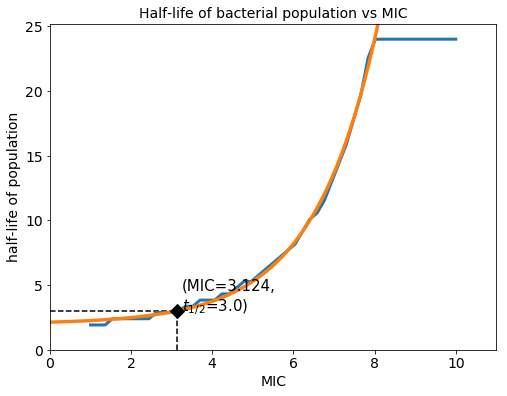

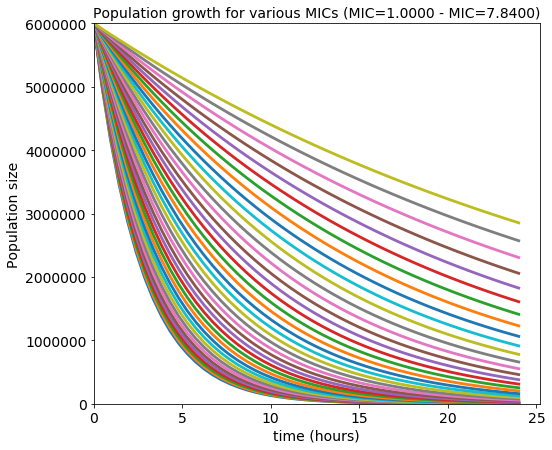

[0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.4897959183673469, 0.5, 0.4897959183673469, 0.48, 0.48, 0.5, 0.48, 0.48, 0.48, 0.48, 0.5106382978723404, 0.4897959183673469, 0.48, 0.5, 0.4897959183673469, 0.4897959183673469, 0.5, 0.5, 0.6486486486486487, 0.7741935483870968, 0.7058823529411765, 0.9230769230769231, 0.8275862068965517, 0.8, 0.8888888888888888, 0.9808695652173912, 1.069090909090909, 1.44, 1.44, 1.44, 1.92, 1.92, 1.92, 2.4, 2.88, 3.36, 3.84, 4.8, 6.72, 10.56, 22.56, 24.0, 24.0, 24.0, 24.0]
8.574999896113724


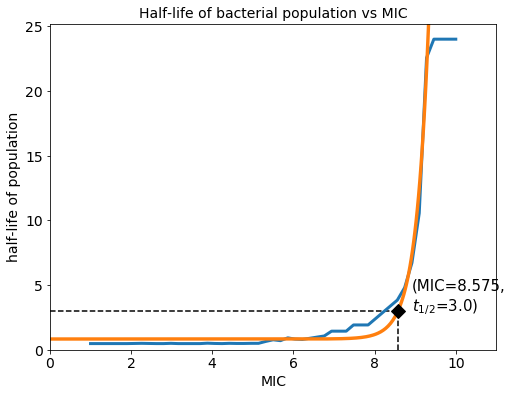

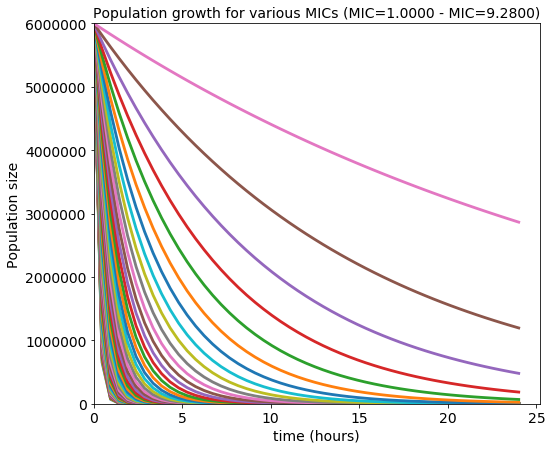

[1.92, 1.92, 1.92, 1.92, 2.4, 2.4, 2.4, 2.4, 2.4, 2.88, 2.88, 2.88, 2.88, 3.36, 3.36, 3.36, 3.84, 3.84, 4.32, 4.32, 4.8, 4.8, 5.28, 5.28, 5.76, 6.240333333333333, 6.72, 7.2, 7.68, 8.1605, 8.6405, 9.6, 10.08, 11.04, 12.0, 13.441, 14.401, 15.841, 17.761, 19.68, 22.56, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0]
3.173956888383621


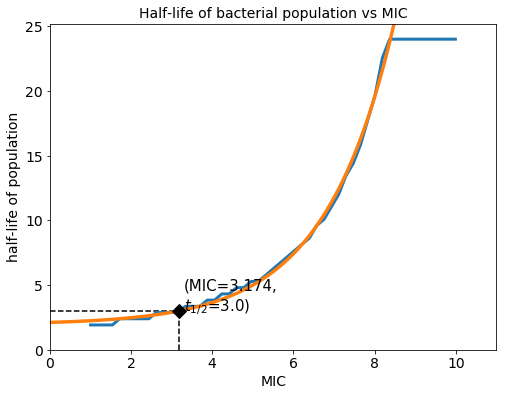

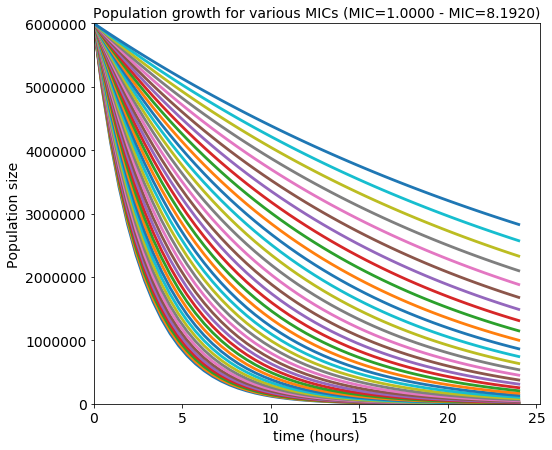

In [63]:
def extractMultipleMICCurves(filename, delim):
    '''returns the list of MICs used, the times sampled over and the corresponding population sizes'''
    
    #filename = 'Pyrithione_MICVarying_c=10.0.txt'
    
    with open(filename) as infile:
        
        reader = csv.reader(infile, delimiter=delim)
        file_headers = next(reader)
        #print(file_headers)
        nCols = len(file_headers) #gets the no. of columns in file, i.e., features of data

        column_array = [[] for i in range(nCols)] #creates an empty array of length nCols to store the data
        
        
        for row in reader:
            for i in range(len(row)):
                column_array[i].append(float(row[i].strip()))
                
        trimmed_headers = [fh.strip() for fh in file_headers[1:]]
                
        return trimmed_headers, column_array[0], column_array[1:]
    
    
def getHalfLifeOfMICCurve(timeData, input_curve):
    
    hl_index = -17
    
    for i in range(1, len(input_curve)):
        if input_curve[i] <= 0.5*input_curve[0]:
            hl_index = i
            break
        
    if hl_index > 0:
        return timeData[hl_index]
    else:
        return timeData[0]
    
def getAvgHalfLifeOfMICCurve(timeData, input_curve):
    
    hl_indexes = [0, 0]
    delta_t = [] # this stores all the half lifes measured in the curve
    # initialised with one value to prevent division by zero
    
    for i in range(1, len(input_curve)):
        if input_curve[i] <= 0.5*input_curve[hl_indexes[-1]]:
            hl_indexes.append(i)
            dt = timeData[hl_indexes[-1]] - timeData[hl_indexes[-2]]
            delta_t.append(dt)
            
    #hl_times = [timeData[i] for i in hl_indexes]
    if len(delta_t):
        return sum(delta_t)/len(delta_t)
    else:
        return max(timeData)
    
    

def plotMultipleMICCurves(filename, delim):
    
    MIC_labels, times, MICpops = extractMultipleMICCurves(filename, delim)
    half_life_lists = [getAvgHalfLifeOfMICCurve(times, mic) for mic in MICpops]
    relevant_hls = [hl for hl in half_life_lists if hl < max(times)]
    MICpops = MICpops[:len(relevant_hls)]
    MIC_labels = MIC_labels[:len(relevant_hls)]
    
    plt.figure(figsize=(8,7))
    for mic in MICpops:
        plt.plot(times, mic, linewidth=2.8)
    
    plt.xlim(0,1.05*max(times))
    y_max = max(max(MICpops))
    plt.ylim(0, y_max)
    
    font_size=14
    plt.tick_params(labelsize=14)
    plt.title('Population growth for various MICs ('+MIC_labels[0]+' - '+MIC_labels[-1]+')', fontsize=font_size)
    plt.xlabel('time (hours)', fontsize=font_size)
    plt.ylabel('Population size', fontsize=font_size)
    #plt.savefig('plots/'+'popSize(t)_vs_MIC.png')
    plt.show()
    
    
    
    
def plotHalfLifesOfMICs(filename, delim):
    
    MIC_labels, times, MICpops = extractMultipleMICCurves(filename, delim)
    half_life_lists = [getAvgHalfLifeOfMICCurve(times, mic) for mic in MICpops]
    #relevant_hls = half_life_lists[:-2] # the non-zero half lifes
    relevant_hls = [hl for hl in half_life_lists if hl < max(half_life_lists)]
    print(half_life_lists)
    MIC_vals = [float(re.findall("\d+\.\d+", MIC_string)[0]) for MIC_string in MIC_labels]
    
    target_halfLife = 4.# the timeframe in hours desired for the population to decrease by half
    target_halfLife2 = 2.
    target_halfLife3 = 3.
    
    def fit_func(x, a, b, c):
        return b*np.exp(a*x) + c
        #return a*x**2 + b*x + c
        #return a*np.exp(-(x-b)**2/(2.*c**2))
    
    '''def objective(x, a, b, c):
        #used to find the x-value of the above function given a y value
        return (target_halfLife - fit_func(x, a, b, c))**2
    
    def objective2(x, a, b, c):
        return (target_halfLife2 - fit_func(x, a, b, c))**2
    '''
    #can make a function iside a function to pass values to the optimizer
    def objective_halfLife(targ_hl):
        
        def objective(x, a, b, c):
        #'''used to find the x-value of the above function given a y value'''
            return (targ_hl - fit_func(x, a, b, c))**2
        return objective
    
    #print(MIC_vals)
    mic_arr = np.array(MIC_vals[:len(relevant_hls)])
    hl_arr = np.array(relevant_hls)
    
    params = curve_fit(fit_func, mic_arr, hl_arr)
    #params = np.polyfit(mic_arr, hl_arr, 2)
    [a1, b1, c1] = params[0] # removed the [0] for the polyfit bit
    
    # here we find the x value (MIC) for a given y-value (half-life)
    def getTargetMIC(targ_hl):
        popt2, pcov2 = curve_fit(fit_func, mic_arr, hl_arr)
        #print(pcov2)
        res = minimize_scalar(objective_halfLife(targ_hl), args=tuple(popt2))
        return res.x # the half life required to obtain target_halfLife
    
    
    target_MIC = getTargetMIC(target_halfLife)
    target_MIC2 = getTargetMIC(target_halfLife2)
    target_MIC3 = getTargetMIC(target_halfLife3)
    print(target_MIC3)
    
    x_vals = np.linspace(0., 12, 400)
    fitted_hls = [fit_func(x, a1, b1, c1) for x in x_vals]
    
    plt.figure(figsize=(8,6))
    plt.plot(MIC_vals, half_life_lists, linewidth=3) #recorded data
    plt.plot(x_vals, fitted_hls, linewidth=3.4) #fitted curve
    
    '''
    plt.plot(target_MIC, target_halfLife, marker='D', markersize=10, color='black') #plot desired MIC for specificied half-life
    plt.vlines(target_MIC, 0, target_halfLife, linestyle="dashed")
    plt.hlines(target_halfLife, 0, target_MIC, linestyle="dashed")
    targMIC_string = "{:.3f}".format(target_MIC)
    plt.text(target_MIC*1.04, target_halfLife *0.96, "(MIC="+targMIC_string+",\n$t_{1/2}$="+str(target_halfLife)+")", fontsize=15)
    
    plt.plot(target_MIC2, target_halfLife2, marker='D', markersize=10, color='black') #plot desired MIC for specificied half-life
    plt.vlines(target_MIC2, 0, target_halfLife2, linestyle="dashed")
    plt.hlines(target_halfLife2, 0, target_MIC2, linestyle="dashed")
    targMIC_string2 = "{:.3f}".format(target_MIC2)
    plt.text(target_MIC2*1.04, target_halfLife2*0.96, "(MIC="+targMIC_string2+",\n$t_{1/2}$="+str(target_halfLife2)+")", fontsize=15)
    '''
    plt.plot(target_MIC3, target_halfLife3, marker='D', markersize=10, color='black') #plot desired MIC for specificied half-life
    plt.vlines(target_MIC3, 0, target_halfLife3, linestyle="dashed")
    plt.hlines(target_halfLife3, 0, target_MIC3, linestyle="dashed")
    targMIC_string3 = "{:.3f}".format(target_MIC3)
    plt.text(target_MIC3*1.04, target_halfLife3*0.96, "(MIC="+targMIC_string3+",\n$t_{1/2}$="+str(target_halfLife3)+")", fontsize=15)
    
    font_size=14
    plt.title('Half-life of bacterial population vs MIC', fontsize=font_size)
    plt.xlabel('MIC', fontsize=font_size)
    plt.ylabel('half-life of population', fontsize=font_size)
    
    plt.tick_params(labelsize=14)
    plt.xlim(0,11.)
    plt.ylim(0,1.05*max(times))
    #plt.savefig('plots/'+'halfLife_vs_MIC.png')
    plt.show()
    
    
    
    
    
#plotHalfLifesOfMICs('Pyrithione_MICVarying_c=10.0.txt')
#plotMultipleMICCurves('Pyrithione_MICVarying_c=10.0.txt')

#plotHalfLifesOfMICs('Pyrithione_MICVarying_c=10.0-extended.txt')
#plotMultipleMICCurves('Pyrithione_MICVarying_c=10.0-extended.txt') 

plotHalfLifesOfMICs('data/Pyrithione-MIC-varying-tau-rescaled.txt', ",")
plotMultipleMICCurves('data/Pyrithione-MIC-varying-tau-rescaled.txt', ",") 

plotHalfLifesOfMICs('data/Pyrithione-MIC-varying-tau-CONFIRM_ORIGINAL_VALUES.txt', ",")
plotMultipleMICCurves('data/Pyrithione-MIC-varying-tau-CONFIRM_ORIGINAL_VALUES.txt', ",") 

plotHalfLifesOfMICs('data/Pyrithione-MIC-varying-tau-correct_gRate.txt', ",")
plotMultipleMICCurves('data/Pyrithione-MIC-varying-tau-correct_gRate.txt', ",") 

fitted MIC: 3.1264077223933397


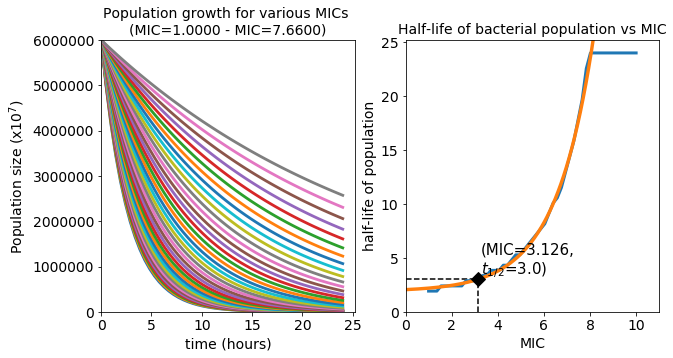

fitted MIC: 8.282908031494255


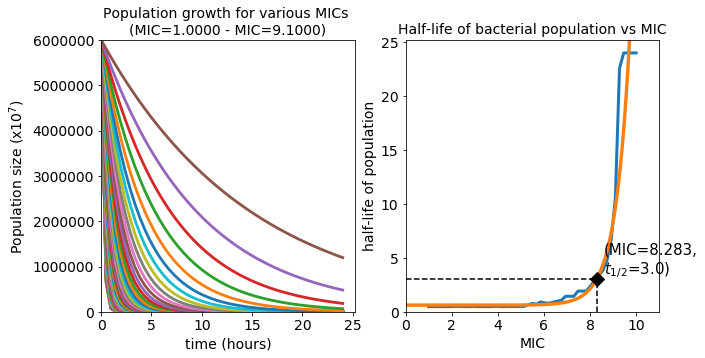

fitted MIC: 7.959235615358675


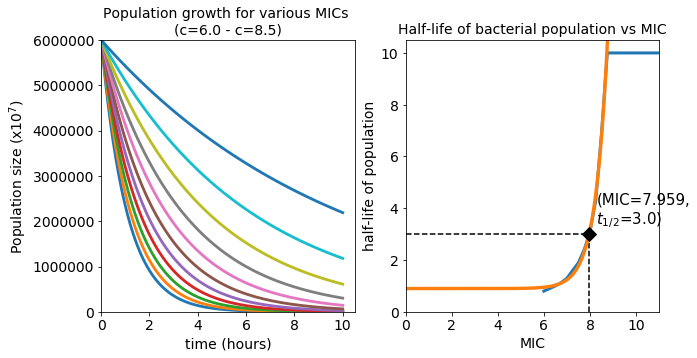

fitted MIC: 3.1791742323506917


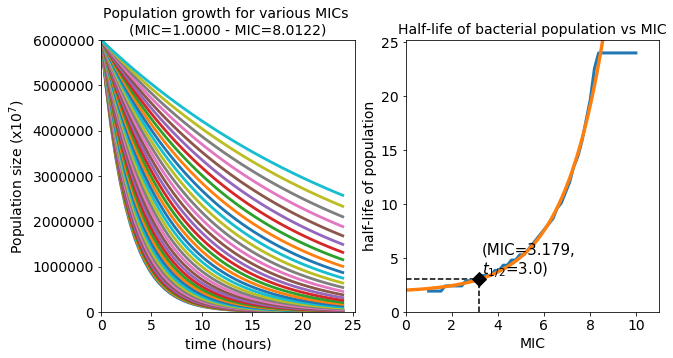

In [64]:
def plotMICsAndHalflivesSideBySide_v2(filename, delim, pic_title):
    
    fig, axarr = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    titleSize = 12
    labelSize = 12
    numbersize = 14
    legendsize = 10
    IDsize = 12
    font_size = 14
    
    
    ############### Multiple MIC curve plotting #################
    MIC_labels, times, MICpops = extractMultipleMICCurves(filename, delim)
    half_life_lists = [getAvgHalfLifeOfMICCurve(times, mic) for mic in MICpops]
    relevant_hls = [hl for hl in half_life_lists if hl < 0.9*max(times)]
    MICpops_all = MICpops.copy()
    MIC_labels_all = MIC_labels.copy()
    MICpops = MICpops[:len(relevant_hls)]
    MIC_labels = MIC_labels[:len(relevant_hls)]
    
    for mic in MICpops:
        axarr[0].plot(times, mic, linewidth=2.8)
    
    axarr[0].set_xlim(0,1.05*max(times))
    y_max = max(max(MICpops))
    axarr[0].set_ylim(0, y_max)
    axarr[0].set_title('Population growth for various MICs \n('+MIC_labels[0]+' - '+MIC_labels[-1]+')', fontsize=font_size)
    axarr[0].set_xlabel('time (hours)', fontsize=font_size)
    axarr[0].set_ylabel('Population size (x10$^7$)', fontsize=font_size)
    
    
    ######### HALF LIFE CURVE FITTING #####################
    
    MIC_vals = [float(re.findall("\d+\.\d+", MIC_string)[0]) for MIC_string in MIC_labels_all]
    
    target_halfLife = 4.# the timeframe in hours desired for the population to decrease by half
    target_halfLife2 = 2.
    target_halfLife3 = 3.
    
    def fit_func(x, a, b, c):
        return b*np.exp(a*x) + c

    #can make a function iside a function to pass values to the optimizer
    def objective_halfLife(targ_hl):
        
        def objective(x, a, b, c):
        #'''used to find the x-value of the above function given a y value'''
            return (targ_hl - fit_func(x, a, b, c))**2
        return objective
    
    
    mic_arr = np.array(MIC_vals[:len(relevant_hls)])
    hl_arr = np.array(relevant_hls)
    
    params = curve_fit(fit_func, mic_arr, hl_arr)
    [a1, b1, c1] = params[0] # removed the [0] for the polyfit bit
    
    # here we find the x value (MIC) for a given y-value (half-life)
    def getTargetMIC(targ_hl):
        popt2, pcov2 = curve_fit(fit_func, mic_arr, hl_arr)
        #print(pcov2)
        res = minimize_scalar(objective_halfLife(targ_hl), args=tuple(popt2))
        return res.x # the half life required to obtain target_halfLife
    
    
    target_MIC = getTargetMIC(target_halfLife)
    target_MIC2 = getTargetMIC(target_halfLife2)
    target_MIC3 = getTargetMIC(target_halfLife3)
    
    x_vals = np.linspace(0., 12, 400)
    fitted_hls = [fit_func(x, a1, b1, c1) for x in x_vals]
    
    axarr[1].plot(MIC_vals, half_life_lists, linewidth=3) #recorded data
    axarr[1].plot(x_vals, fitted_hls, linewidth=3.4) #fitted curve

    axarr[1].plot(target_MIC3, target_halfLife3, marker='D', markersize=10, color='black') #plot desired MIC for specificied half-life
    axarr[1].vlines(target_MIC3, 0, target_halfLife3, linestyle="dashed")
    axarr[1].hlines(target_halfLife3, 0, target_MIC3, linestyle="dashed")
    targMIC_string3 = "{:.3f}".format(target_MIC3)
    axarr[1].text(target_MIC3*1.04, target_halfLife3*(1.+0.10), "(MIC="+targMIC_string3+",\n$t_{1/2}$="+str(target_halfLife3)+")", fontsize=15)
    
    axarr[1].set_title('Half-life of bacterial population vs MIC', fontsize=font_size)
    axarr[1].set_xlabel('MIC', fontsize=font_size)
    axarr[1].set_ylabel('half-life of population', fontsize=font_size)
    
    axarr[1].set_xlim(0,11.)
    axarr[1].set_ylim(0,1.05*max(times))

    
    for ax in axarr:
        ax.xaxis.set_tick_params(labelsize=numbersize)
        ax.yaxis.set_tick_params(labelsize=numbersize)
        
    print("fitted MIC: "+str(target_MIC3))
    plt.savefig('plots/'+pic_title, bbox_inches='tight')
    plt.show()
    
    
plotMICsAndHalflivesSideBySide_v2('data/Pyrithione-MIC-varying-tau-rescaled.txt', ",", 'MIC_hl_curves_tau_rescaled.pdf')
plotMICsAndHalflivesSideBySide_v2('data/Pyrithione-MIC-varying-tau-CONFIRM_ORIGINAL_VALUES.txt', ",", 'MIC_hl_curves_tau_orig_vals.pdf')
plotMICsAndHalflivesSideBySide_v2('data/Pyrithione_MICVarying_c=10.0-extended.txt', "\t", 'MIC_hl_curves_montecarlo_original.pdf')
plotMICsAndHalflivesSideBySide_v2('data/Pyrithione-MIC-varying-tau-correct_gRate.txt', ',', 'MIC_hl_curves_tau_correct_gRate.pdf')

100000
max: 32.9871
min: 0.258
avg: 3.179378658999972


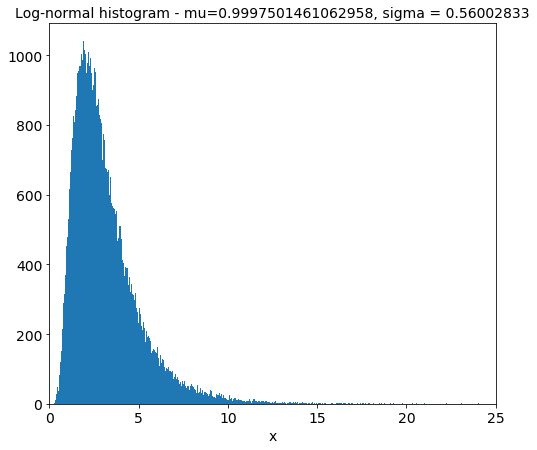

100000
max: 132.656
min: 0.0279
avg: 3.179777945000033


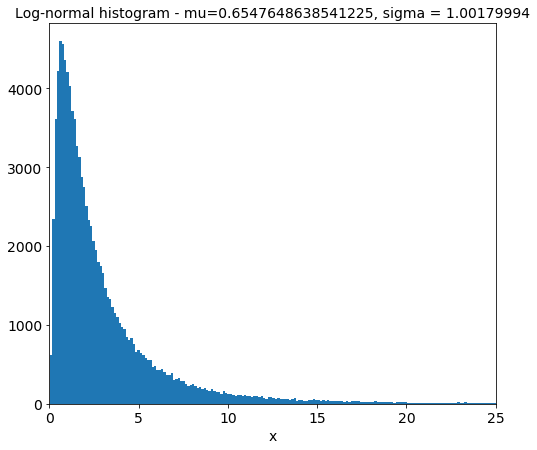

100000
max: 1385.2841
min: 0.0019
avg: 3.2424292200000027


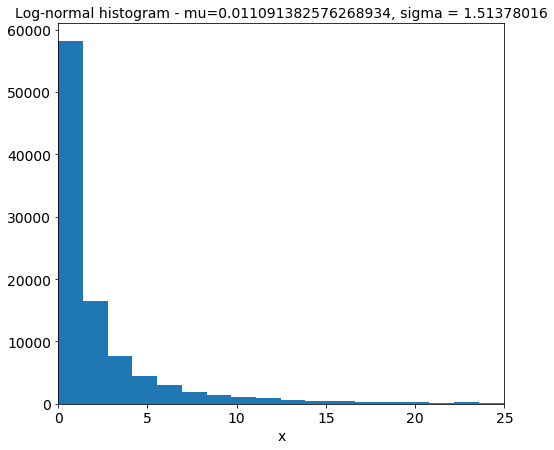

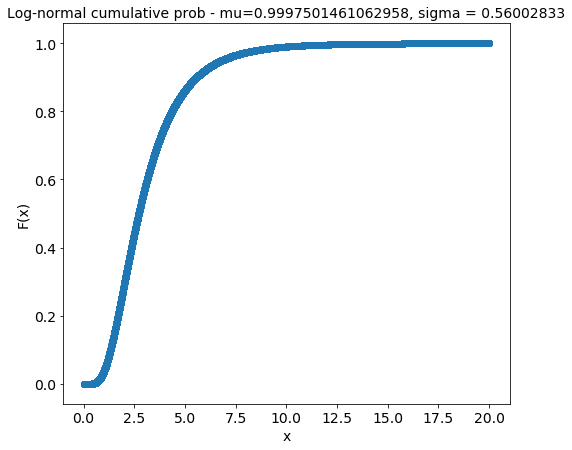

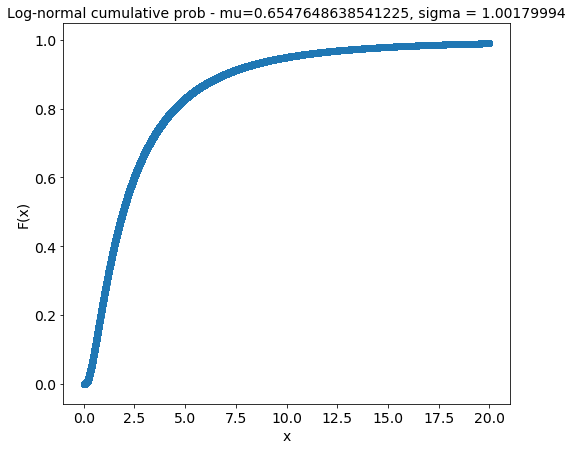

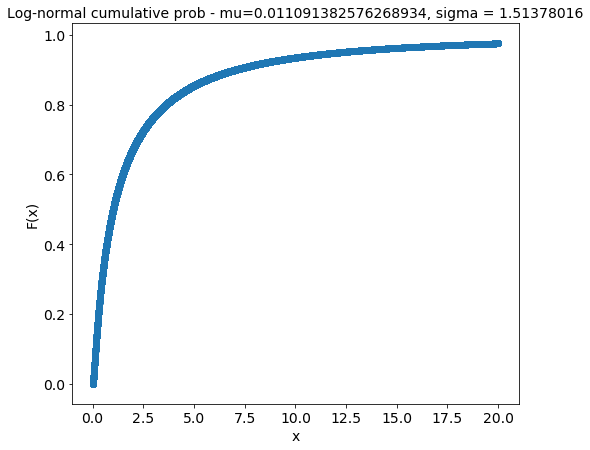

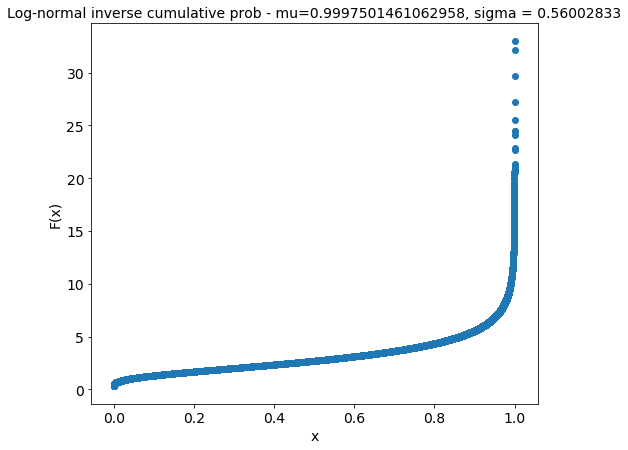

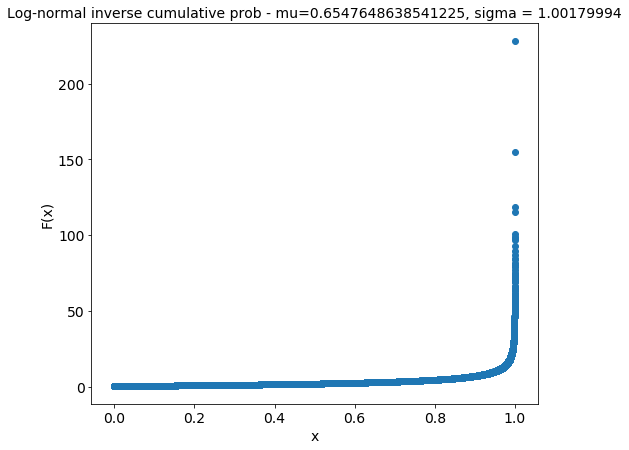

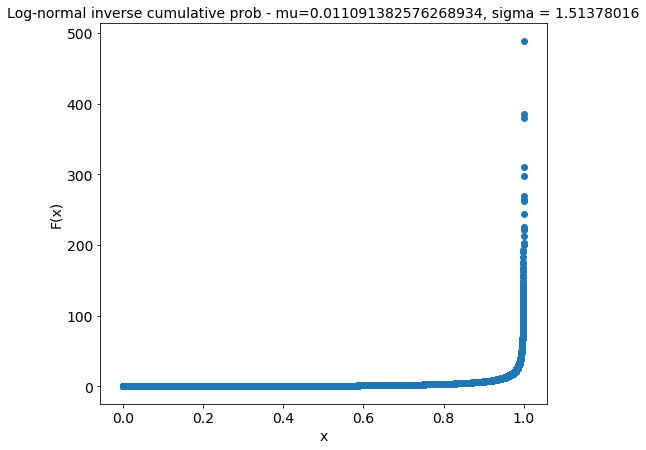

In [77]:
def histogramLogNorms(filename):
    p = re.compile(r'\d+\.\d+')  # Compile a pattern to capture float values
    mu, sigma = [float(i) for i in p.findall(filename)]
    column_array = [] #creates an empty array of length nCols to store the data
    with open(filename) as infile:
        
        reader = csv.reader(infile)
        
        for row in reader:
            column_array.append(float(row[0]))
                
    #column_array = [x for x in column_array if x < 100 ]
    print(len(column_array))
    print("max: "+str(max(column_array)))
    print("min: "+str(min(column_array)))
    #avg = sum(column_array)
    print("avg: "+str(sum(column_array)/len(column_array)))
    font_size = 14
    
    plt.figure(figsize=(8,7))
    plt.hist(column_array, bins=1000)
    
    plt.tick_params(labelsize=14)
    plt.title('Log-normal histogram - mu='+str(mu)+', sigma = '+str(sigma), fontsize=font_size)
    plt.xlabel('x', fontsize=font_size)
    plt.xlim(0,25)

    plt.savefig('LogNormPlots/logNorm-histo-mu='+str(mu)+'-sigma='+str(sigma)+'.png')
    plt.show()
    
    
    
def plotCumlProbLogNorm(filename):
    p = re.compile(r'\d+\.\d+')  # Compile a pattern to capture float values
    mu, sigma = [float(i) for i in p.findall(filename)]
    
    def getFileVals(filename):
        with open(filename) as infile:
            
            reader = csv.reader(infile, delimiter="\t")
            nCols = len(next(reader)) #gets the no. of columns in file, i.e., features of data
            infile.seek(0)
            
            column_array = [[] for i in range(nCols)] #creates an empty array of length nCols to store the data
        
        
            for row in reader:
                for i in range(len(row)):
                    column_array[i].append(float(row[i].strip()))
                    
            return column_array[0], column_array[1]
        
        
    xVals, yVals = getFileVals(filename)
    
    font_size=14
    plt.figure(figsize=(8,7))
    plt.scatter(xVals, yVals)
    
    plt.tick_params(labelsize=14)
    plt.title('Log-normal cumulative prob - mu='+str(mu)+', sigma = '+str(sigma), fontsize=font_size)
    plt.xlabel('x', fontsize=font_size)
    plt.ylabel('F(x)', fontsize=font_size)


    plt.savefig('LogNormPlots/logNorm-cumlProb-mu='+str(mu)+'-sigma='+str(sigma)+'.png')
    plt.show()
    
    
def plotInvCumlProb(filename):
    p = re.compile(r'\d+\.\d+')  # Compile a pattern to capture float values
    mu, sigma = [float(i) for i in p.findall(filename)]
    def getFileVals(filename):
        with open(filename) as infile:
            
            reader = csv.reader(infile, delimiter="\t")
            nCols = len(next(reader)) #gets the no. of columns in file, i.e., features of data
            infile.seek(0)
            
            column_array = [[] for i in range(nCols)] #creates an empty array of length nCols to store the data
        
        
            for row in reader:
                for i in range(len(row)):
                    column_array[i].append(float(row[i].strip()))
                    
            return column_array[0], column_array[1]
        
        
    xVals, yVals = getFileVals(filename)
    
    font_size=14
    plt.figure(figsize=(8,7))
    plt.scatter(xVals, yVals)
    
    plt.tick_params(labelsize=14)
    plt.title('Log-normal inverse cumulative prob - mu='+str(mu)+', sigma = '+str(sigma), fontsize=font_size)
    plt.xlabel('x', fontsize=font_size)
    plt.ylabel('F(x)', fontsize=font_size)


    plt.savefig('LogNormPlots/logNorm-invCumlProb-mu='+str(mu)+'-sigma='+str(sigma)+'.png')
    plt.show()
    
    
#histogramLogNorms('lognormal-samples.txt')
#histogramLogNorms('LogNormRawData/lognormal-samples_mu=2.069402935555521_sigma=0.1002622.txt')
#plotCumlProbLogNorm('LogNormRawData/cumulProbs_mu=2.069402935555521_sigma=0.1002622.txt')
#plotInvCumlProb('LogNormRawData/inverseCumulProbs_mu=2.069402935555521_sigma=0.1002622.txt')
histogramLogNorms('LogNormRawData/lognormal-samples_mu=0.9997501461062958_sigma=0.56002833.txt')
histogramLogNorms('LogNormRawData/lognormal-samples_mu=0.6547648638541225_sigma=1.00179994.txt')
histogramLogNorms('LogNormRawData/lognormal-samples_mu=0.011091382576268934_sigma=1.51378016.txt')

plotCumlProbLogNorm('LogNormRawData/cumulProbs_mu=0.9997501461062958_sigma=0.56002833.txt')
plotCumlProbLogNorm('LogNormRawData/cumulProbs_mu=0.6547648638541225_sigma=1.00179994.txt')
plotCumlProbLogNorm('LogNormRawData/cumulProbs_mu=0.011091382576268934_sigma=1.51378016.txt')

plotInvCumlProb('LogNormRawData/inverseCumulProbs_mu=0.9997501461062958_sigma=0.56002833.txt')
plotInvCumlProb('LogNormRawData/inverseCumulProbs_mu=0.6547648638541225_sigma=1.00179994.txt')
plotInvCumlProb('LogNormRawData/inverseCumulProbs_mu=0.011091382576268934_sigma=1.51378016.txt')

In [70]:
def getMuAndSigma4(target_mic, percentile_resistant, percentile_resistVal, mu_guess, sigma_guess):
    '''given a desired value for the cdf at a given mic, returns scale and sigma based on the % resitant at that mic
    i.e minimises (%resistant - cdf(given MIC))**2
    
    Here mu is not really mu, but is actually the "scale" parameter of the distribution
    
    percentile_resistant is the percentile of the genotypes which have a value equal to percentile_resistVal
    
    percentile_resistval is the resistance level of the 99th percentile of the genotype distributions
    
    this returns the scale and sigma needed for the lognormal distributions'''
    #f_inv_val = 1. - percent_resist #the target value of the inverse cuml func: f(target_mean)^-1
    

    
    # returns the value of the cdf for a given mic
    def func(params):
        mu, sigma = params
        #print(stats.lognorm(s=sigma, scale=math.exp(mu)).cdf(target_mic))
        #minimises the value of the target percentile to 10, and also the mean to target_mic
        minimise_percentile = (percentile_resistant - stats.lognorm(s=sigma, scale=mu).cdf(percentile_resistVal))**2
        logNormMean = stats.lognorm(s=sigma, scale=mu).mean()
        minimiseMean = (target_mic - logNormMean)**2
        return minimise_percentile + minimiseMean
    
    # returns value of ppf for a given desired resistance percentage
    def func2(params):
        mu, sigma = params
        #print(stats.lognorm(s=sigma, scale=math.exp(mu)).cdf(target_mic))
        return (target_mic - stats.lognorm(s=sigma, scale=mu).ppf(f_inv_val))**2
    
    
    
    params0 = [mu_guess, sigma_guess]
    result = minimize(func, params0, method = 'Nelder-Mead')
    print("scale, sigma: "+str(result.x))
    print("log(mu): "+str(math.log(result.x[0])))
    
    mu_fit, sigma_fit = result.x
    
    rvs = lognorm.cdf(target_mic,s=sigma_fit, scale=mu_fit)
    rvs2 = stats.lognorm(s=sigma_fit, scale=mu_fit).cdf(target_mic)
    rvs3 = lognorm(s=sigma_fit, scale=mu_fit).mean()
    rvs4 = lognorm(s=sigma_fit, scale=mu_fit).cdf(percentile_resistVal)
    #j = stats.lognorm.ppf(target_mic, s=sigma, scale=math.exp(mu))
    print("val of cdf at avg_mic: "+str(rvs))
    print("val of cdf at percentile resist val: "+str(rvs4))
    print("mean of distb: "+str(rvs3))
    print()
    
    #params0 = [0.1, 6]
    #result = minimize(func2, params0, method = 'Nelder-Mead')
    #print(result.x)
    
   
    
#getMuAndSigma4(7.96, 0.99, 10.)  
getMuAndSigma4(3.179, 0.99, 10, 3., 0.6)
getMuAndSigma4(3.179, 0.95, 10, 2., 1.)
getMuAndSigma4(3.179, 0.90, 10, 1.1, 1.6)

mu, sigma: [2.71760274 0.56002833]
log(mu): 0.9997501472875354
val of cdf at avg_mic: 0.6102671399977654
val of cdf at percentile resist val: 0.9900006773039464
mean of distb: 3.178997870729277

mu, sigma: [1.9246899  1.00179994]
log(mu): 0.6547648652527422
val of cdf at avg_mic: 0.6917793283014342
val of cdf at percentile resist val: 0.950000613802379
mean of distb: 3.1789991852371484

mu, sigma: [1.01115312 1.51378016]
log(mu): 0.011091378838280588
val of cdf at avg_mic: 0.775384768140313
val of cdf at percentile resist val: 0.9349561247452548
mean of distb: 3.179921675573653



479
10.000051999340831


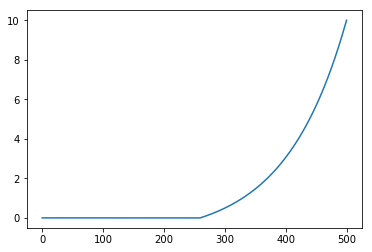

In [13]:
def plotConcentrationProfile():
    
    xVals = np.arange(0, 500)
    
    yVals = [math.e**(0.01*(x-259.21))-1 if x>=259 else 0 for x in xVals]
    
    mean_val_reached = next(i for i in range(len(yVals)) if yVals[i] > 7.96)
    print(mean_val_reached)
    print(max(yVals))
    plt.plot(xVals, yVals)
    plt.show()
    
    
plotConcentrationProfile()